## 5.9 Regression 실습 - Bike Sharing Demand
### 데이터 클렌징 및 가공

### 1. 데이터 분석에 필요한 전처리를 하시오.
#### 1-1. 년, 월, 일, 시간, 요일 변수 생성
#### 1-2. datetime, casual, registered 값 삭제
#### 1-3. windspeed 값이 '0'인 경우 평균값으로 대체
### 2. 'temp', 'atemp', 'humidity', 'windspeed', 'count' 변수간 상관계수 구하고, 히트맵으로 시각화 하시오.

### 3. 기본 선형회귀모델 결과를 토대로 유의미한 변수를 고르시오.

### 4. 세가지 이상의 모델로 회귀분석을 하고 각각의 장단점을 기술하시오. 성능이 좋은 모델의 결과값을 submission 파일로 제출하시오.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('C:/Users/DS\Downloads/bike-sharing-demand/train.csv')
print(bike_df.shape)
bike_df.head(3)

In [ ]:
bike_df.info()
# 결측값 확인, datetime 데이터타입 확인

### 1. 데이터 분석에 필요한 전처리를 하시오.
#### 1-1. 년, 월, 일, 시간, 요일 변수 생성
#### 1-2. datetime, casual, registered 값 삭제
#### 1-3. windspeed 값이 '0'인 경우 평균값으로 대체

In [ ]:
# 1-1 풀이
# 문자열을 datetime 타입으로 변경. 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간, 요일 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df['dayofweek'] = bike_df.datetime.apply(lambda x: x.dayofweek) ## 요일 계산

bike_df.head(3)

In [ ]:
# 1-2 풀이
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)
bike_df.head(3)

In [ ]:
# 1-3 풀이
bike_df.loc[bike_df['windspeed'] == 0, 'windspeed'] = bike_df['windspeed'].mean()
print(bike_df['windspeed'].value_counts())

<AxesSubplot:xlabel='hour', ylabel='count'>

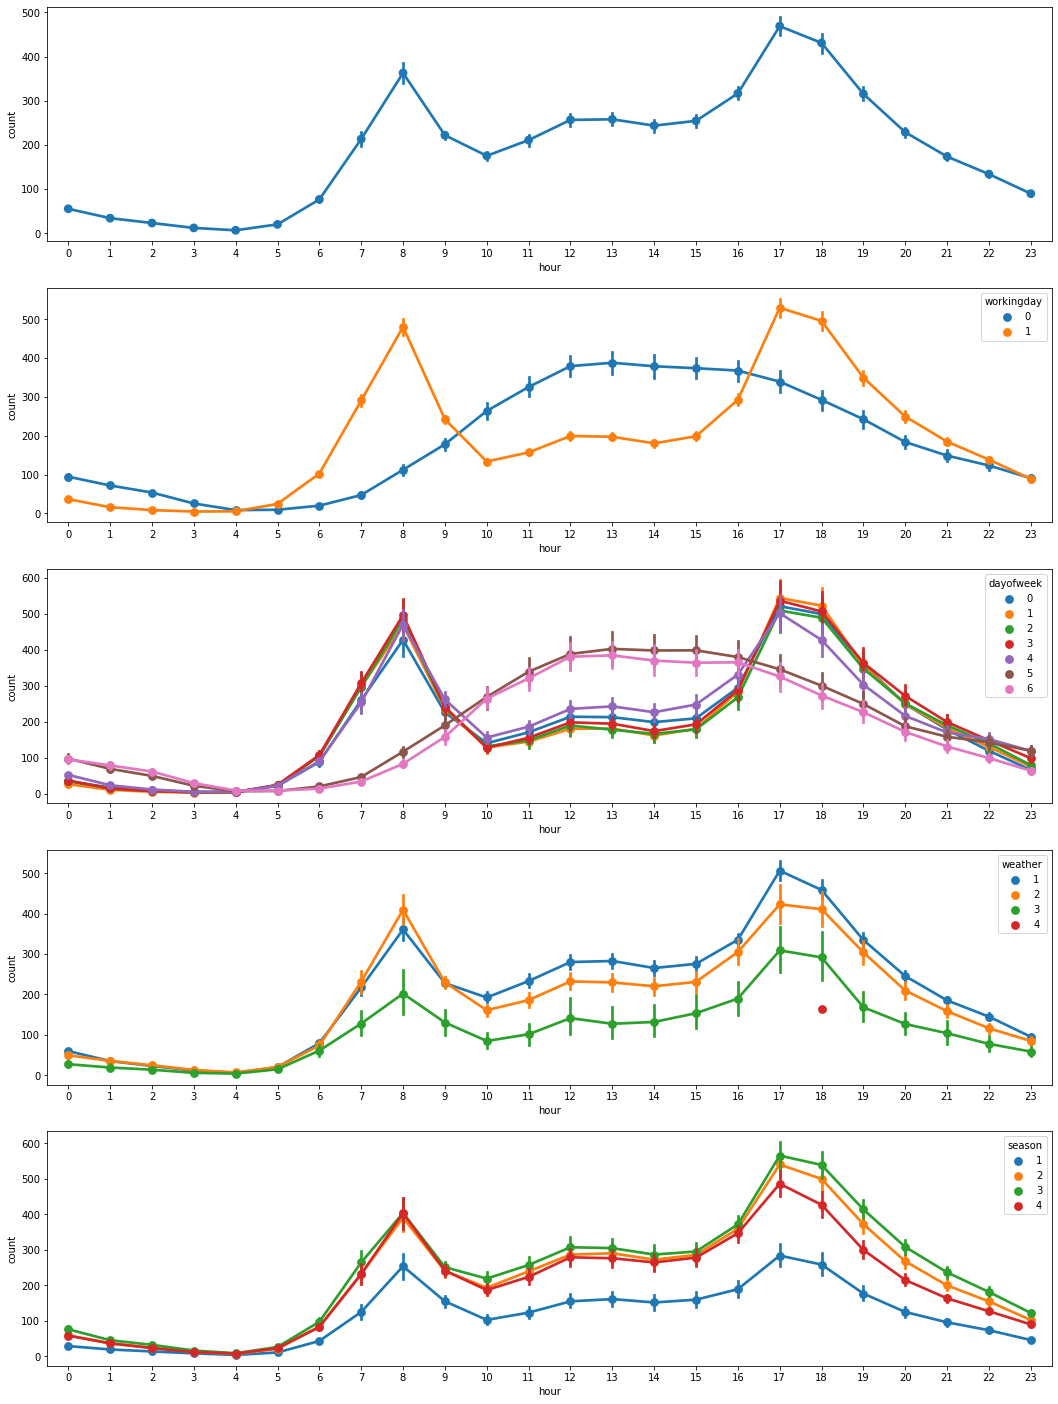

In [5]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=bike_df, x='hour', y='count', ax=ax1)
sns.pointplot(data=bike_df, x='hour', y='count', hue='workingday', ax=ax2)
sns.pointplot(data=bike_df, x='hour', y='count', hue='dayofweek', ax=ax3)
sns.pointplot(data=bike_df, x='hour', y='count', hue='weather', ax=ax4)
sns.pointplot(data=bike_df, x='hour', y='count', hue='season', ax=ax5)

### 2. 'temp', 'atemp', 'humidity', 'windspeed', 'count' 변수간 상관계수 구하고, 히트맵으로 시각화 하시오.


In [6]:
# 2 히트맵 시각화
corrMatt = bike_df[['temp', 'atemp', 'humidity', 'windspeed', 'count']]
corrMatt = corrMatt.corr()
print(corrMatt)

               temp     atemp  humidity  windspeed     count
temp       1.000000  0.984948 -0.064949  -0.017852  0.394454
atemp      0.984948  1.000000 -0.043536  -0.057473  0.389784
humidity  -0.064949 -0.043536  1.000000  -0.318607 -0.317371
windspeed -0.017852 -0.057473 -0.318607   1.000000  0.101369
count      0.394454  0.389784 -0.317371   0.101369  1.000000


<AxesSubplot:>

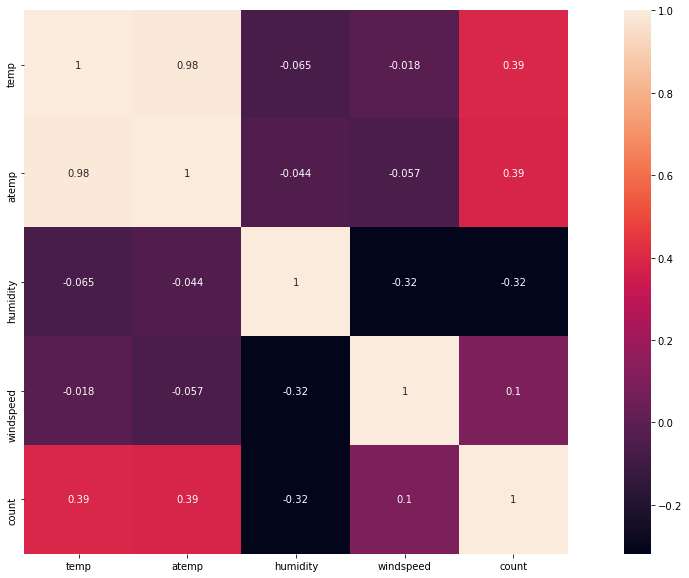

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, square=True, annot=True)

## count와 상관관계가 가장 높은 변수로는 temp, atemp가 있음
## windspeed 는 상관관계가 높을것으로 예상되지만 낮게 나왔음, '0'값에 대한 전처리 및 대여량에 영향을 주는지 여부에 따른 범주화 구분 필요할듯함
## temp와 atemp가 0.98로 상관관계가 매우 높게 나왔는데.. 이는 온도와, 체감온도이기 때문에 하나만 사용해야 할수 있음

### 3. 기본 선형회귀모델 결과를 토대로 유의미한 변수를 고르시오.

### 로그 변환, 피처 인코딩, 모델 학습/예측/평가 

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [18]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.176, RMSE: 140.895, MAE: 105.920


In [19]:
import statsmodels.api as sm

model = sm.OLS(y_train, X_train)
result = model.fit()

print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  count   R-squared (uncentered):                   0.685
Model:                            OLS   Adj. R-squared (uncentered):              0.685
Method:                 Least Squares   F-statistic:                              1274.
Date:                Sat, 26 Feb 2022   Prob (F-statistic):                        0.00
Time:                        22:34:08   Log-Likelihood:                         -48868.
No. Observations:                7620   AIC:                                  9.776e+04
Df Residuals:                    7607   BIC:                                  9.785e+04
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### 4. 세가지 이상의 모델로 회귀분석을 하고 각각의 장단점을 기술하시오. 성능이 좋은 모델의 결과값을 submission 파일로 제출하시오.

#### 필요한 경우 preprocessing 하시오


In [35]:
## year', month', 'day', 'hour', 'weekofday' 등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'dayofweek', 'holiday',
                                              'workingday','season','weather'])



In [29]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target,
                                                    test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 0.837, RMSE: 101.465, MAE: 74.768


In [ ]:
X_features_ohe

<AxesSubplot:>

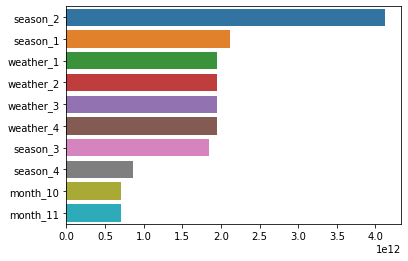

In [24]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index)


In [25]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_test)

evaluate_regr(y_test ,pred)




RMSLE: 0.484, RMSE: 54.348, MAE: 33.510


In [26]:
xgb_reg = XGBRegressor(n_estimators=500)
xgb_reg.fit(X_train, y_train)
pred = xgb_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 0.505, RMSE: 47.107, MAE: 30.299


In [ ]:
## 원핫인코딩 처리된것 statmodels로 결과 보기

import statsmodels.api as sm

model = sm.OLS(y_train, X_train)
result = model.fit()

print(result.summary())

https://ysyblog.tistory.com/119